# Mise en place des différents modèles prédictifs

## Chargement et préparation des données

Nous allons commencer par importer les bibliothèques requises pour nos différents modèles, ainsi que la base de données préalablement formatée pour cette étude.

In [1]:
#On importe les bibliothèques requises
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import timeit

#Nous aurons également besoin de plusieurs fonctions de scikit-learn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import kernel_ridge
from sklearn import dummy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#Ainsi que le regrésseur XGBoost
from xgboost import XGBRegressor

#On charge les bases de données d'entrainement et de test (nettoyées et formatées à l'avance)
train_ghg = pd.read_csv('database_train_ghg.csv')
test_ghg = pd.read_csv('database_test_ghg.csv')
train_nrj = pd.read_csv('database_train_nrj.csv')
test_nrj = pd.read_csv('database_test_nrj.csv')

#On affiche brièvement la base d'entraînement pour vérification
print(train_ghg.shape, test_ghg.shape, train_nrj.shape, test_nrj.shape)
print(train_ghg.columns)
print(train_nrj.columns)

(2315, 15) (579, 15) (2315, 15) (579, 15)
Index(['ENERGYSTARScore', 'LargestPropertyUseTypeGFA', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'GHGE_log', 'Hôtel', 'Entrepôt', 'Autre', 'Magasin', 'Bureaux', 'Ecole',
       'Age'],
      dtype='object')
Index(['ENERGYSTARScore', 'LargestPropertyUseTypeGFA', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'SEU_log', 'Hôtel', 'Entrepôt', 'Autre', 'Magasin', 'Bureaux', 'Ecole',
       'Age'],
      dtype='object')


Nous allons extraire et renommer les différentes données d'entraînement et de tests que nous utiliserons. Rappelons que nous devons étudier 2 prédictions séparément : la consommation d'énergie ainsi que l'émission de gaz à effets de serre.

In [2]:
#On construit les échantillons qui vont nous intéresser, i.e. les variables d'entrainement et de test
X_train_ghg = train_ghg.drop(columns = ['GHGE_log', 'ENERGYSTARScore'])
X_test_ghg = test_ghg.drop(columns = ['GHGE_log', 'ENERGYSTARScore'])
X_train_nrj = train_nrj.drop(columns = ['SEU_log', 'ENERGYSTARScore'])
X_test_nrj = test_nrj.drop(columns = ['SEU_log', 'ENERGYSTARScore'])
#Il faut bien séparer les variables à prédire "y" en fonction du problème considéré, avec toujours entraînement et test
y_train_ghg = train_ghg['GHGE_log']
y_test_ghg = test_ghg['GHGE_log']
y_train_nrj = train_nrj['SEU_log']
y_test_nrj = test_nrj['SEU_log']

Nous allons également préparer deux DataFrames vides qui contiendront les indicateurs de performances de nos différents modèles pour comparaison et sélection du modèle le plus efficace. Nous considèrerons quatre indicateurs de performances de nos modèles : 
- la racine de l'erreur quadratique moyenne RMSE, afin de mesurer l'erreur faite sur nos prédictions,
- le coefficient de détermination R² qui quantifie le pouvoir explicatif de notre modèle,
- le pourcentage d'erreur relative moyenne MAPE, qui est plus explicite et interprétable que la RMSE,
- le temps de calcul du modèle, qui aura son importance puisque l'optimisation par validation croisée demandera de construire un même modèle un grand nombre de fois.

In [3]:
#On prépare les deux DataFrames vides
indicateurs_ghg = pd.DataFrame(index = ['RMSE train', 'RMSE test', 'R² train', 'R² test', 'MAPE train', 'MAPE test', "time"])
indicateurs_nrj = pd.DataFrame(index = ['RMSE train', 'RMSE test', 'R² train', 'R² test', 'MAPE train', 'MAPE test', "time"])

#Il nous faudra une fonction pour facilement retransformer nos variables
def exp_var(y):
    res = np.exp(y)
    return res

#Une fonction nous permettra d'évaluer ses performances pour nos différents indicateurs,
#sur le jeu d'entraînement comme sur le jeu de test, en tenant compte de la transformation des variables
def indic_performances(modele, X_train, y_train, X_test, y_test):
    y_simul = modele.predict(X_train)
    y_pred = modele.predict(X_test)    
    #Il nous faut transformer les variables fournies et prédites en les passant à l'exponentielle
    y_train_exp = exp_var(y_train)
    y_test_exp = exp_var(y_test)
    y_simul_exp = exp_var(y_simul)
    y_pred_exp = exp_var(y_pred)
    #Nous utiliserons comme indicateurs la RMSE, le R² ainsi que la MAPE sur les jeux de train et de test
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train_exp, y_simul_exp))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test_exp, y_pred_exp))
    r2_train = metrics.r2_score(y_train_exp, y_simul_exp)
    r2_test = metrics.r2_score(y_test_exp, y_pred_exp)
    mape_train = metrics.mean_absolute_percentage_error(y_train_exp, y_simul_exp)
    mape_test = metrics.mean_absolute_percentage_error(y_test_exp, y_pred_exp)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test)

## Modèle naïf

On commence par mettre en place un modèle prédictif naïf, qui se contente de renvoyer la médiane de la variable cible dans notre jeu d'entraînement. Ceci nous servira de base pour comparer l'efficacité des modèles plus complexes que nous testerons par la suite.

In [4]:
#On définit une fonction mettant en place une régression naïve
#et évaluant ses performances sur les jeux de train et de test
def regression_naive_base(X_train, y_train, X_test, y_test, methode = 'median'):
    #On construit le modèle via sklearn et on l'initialise avec la "stratégie" retenue
    dummR = dummy.DummyRegressor(strategy=methode)
    #On retient le temps de démarrage du calcul, avant de calquer le modèle sur le jeu de train
    start_time = timeit.default_timer()
    dummR.fit(X_train, y_train)
    #On récupère le temps de calcul, ainsi que les prédictions sur les deux jeux pour évaluer les performances
    elapsed = timeit.default_timer() - start_time
    #On récupère les indicateurs de performances de ce modèle
    (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test) =\
            indic_performances(dummR, X_train, y_train, X_test, y_test)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test, elapsed)

Nous allons appliquer notre fonction nouvellement créée aux deux jeux de données d'entraînement, pour prédire respectivement les émissions de gaz à effets de serre et la consommation d'énergie. Dans les deux cas nous ne conserverons que les indicateurs de performance, puisque nous devrons recalculer le modèle que nous sélectionnerons afin de l'optimiser.

In [5]:
#On simule notre modèle dans les deux cas, en sauvegardant nos indicateurs
indicateurs_ghg['Baseline naïve'] = regression_naive_base(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)
indicateurs_nrj['Baseline naïve'] = regression_naive_base(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

In [6]:
#On va afficher nos indicateurs de performance :
print("Performances du modèle naïf (médiane) pour la prédiction de l'émission de gaz à effets de serre :")
print(indicateurs_ghg['Baseline naïve'])
print("Performances du modèle naïf (médiane) pour la prédiction de la consommation d'énergie :")
print(indicateurs_nrj['Baseline naïve'])

Performances du modèle naïf (médiane) pour la prédiction de l'émission de gaz à effets de serre :
RMSE train    2.012064
RMSE test     2.240513
R² train     -0.120505
R² test      -0.178690
MAPE train    1.071710
MAPE test     0.940943
time          0.001881
Name: Baseline naïve, dtype: float64
Performances du modèle naïf (médiane) pour la prédiction de la consommation d'énergie :
RMSE train    2.274009
RMSE test     2.440417
R² train     -0.145237
R² test      -0.184020
MAPE train    0.904661
MAPE test     0.868021
time          0.000639
Name: Baseline naïve, dtype: float64


## Régression linéaire

Nous allons mettre en place une régression linéaire basique afin d'observer les performances des régressions linéaires indépendamment du choix d'éventuels hyperparamètres. Cela nous servira de baseline si les performances sont meilleure que pour la modèle naïf.

In [7]:
#On définit une fonction mettant en place une régression linéaire basique
#et évaluant ses performances sur les jeux de train et de test
def regression_lineaire_base(X_train, y_train, X_test, y_test):
    #On construit le modèle via sklearn et on l'initialise avec le paramètre a
    lineaire = linear_model.LinearRegression()
    #On retient le temps de démarrage du calcul, avant de calquer le modèle sur le jeu de train
    start_time = timeit.default_timer()
    lineaire.fit(X_train, y_train)
    #On récupère le temps de calcul, ainsi que les prédictions sur les deux jeux pour évaluer les performances
    elapsed = timeit.default_timer() - start_time
    #On récupère les indicateurs de performances de ce modèle
    (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test) =\
            indic_performances(lineaire, X_train, y_train, X_test, y_test)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test, elapsed)

Nous allons appliquer notre fonction nouvellement créée aux deux jeux de données d'entraînement, pour prédire respectivement les émissions de gaz à effets de serre et la consommation d'énergie. Dans les deux cas nous ne conserverons que les indicateurs de performance, puisque nous devrons recalculer le modèle que nous sélectionnerons afin de l'optimiser.

In [8]:
#On simule notre modèle dans les deux cas, en sauvegardant nos indicateurs
indicateurs_ghg['Régression linéaire'] = regression_lineaire_base(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)
indicateurs_nrj['Régression linéaire'] = regression_lineaire_base(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

In [9]:
#On va afficher nos indicateurs de performance :
print("Performances de la régression linéaire basique pour la prédiction de l'émission de gaz à effets de serre :")
print(indicateurs_ghg['Régression linéaire'])
print("Performances de la régression linéaire basique pour la prédiction de la consommation d'énergie :")
print(indicateurs_nrj['Régression linéaire'])

Performances de la régression linéaire basique pour la prédiction de l'émission de gaz à effets de serre :
RMSE train    3.190162
RMSE test     4.949851
R² train     -1.816799
R² test      -4.752925
MAPE train    0.837635
MAPE test     0.789017
time          1.016166
Name: Régression linéaire, dtype: float64
Performances de la régression linéaire basique pour la prédiction de la consommation d'énergie :
RMSE train     8.174411
RMSE test     13.245934
R² train     -13.798724
R² test      -33.881592
MAPE train     0.706548
MAPE test      0.697613
time           0.001711
Name: Régression linéaire, dtype: float64


## Régression ridge linéaire

Nous allons mettre en place une régression ridge linéaire afin d'avoir une régression linéaire qui conserve des poids relativement faible. Nous allons utiliser une valeur par défaut pour le coefficient de régularisation, nous l'optimiserons plus tard si ce modèle est sélectionné.

In [10]:
#On définit une fonction mettant en place une régression linéaire ridge
#et évaluant ses performances sur les jeux de train et de test
def regression_ridge_base(X_train, y_train, X_test, y_test, a = 1):
    #On construit le modèle via sklearn et on l'initialise avec le paramètre a
    ridge = linear_model.Ridge()
    ridge.set_params(alpha=a)
    #On retient le temps de démarrage du calcul, avant de calquer le modèle sur le jeu de train
    start_time = timeit.default_timer()
    ridge.fit(X_train, y_train)
    #On récupère le temps de calcul, ainsi que les prédictions sur les deux jeux pour évaluer les performances
    elapsed = timeit.default_timer() - start_time
    #On récupère les indicateurs de performances de ce modèle
    (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test) =\
            indic_performances(ridge, X_train, y_train, X_test, y_test)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test, elapsed)

Nous allons appliquer notre fonction nouvellement créée aux deux jeux de données d'entraînement, pour prédire respectivement les émissions de gaz à effets de serre et la consommation d'énergie. Dans les deux cas nous ne conserverons que les indicateurs de performance, puisque nous devrons recalculer le modèle que nous sélectionnerons afin de l'optimiser.

In [11]:
#On simule notre modèle dans les deux cas, en sauvegardant nos indicateurs
indicateurs_ghg['Ridge linéaire'] = regression_ridge_base(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)
indicateurs_nrj['Ridge linéaire'] = regression_ridge_base(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

In [12]:
#On va afficher nos indicateurs de performance :
print("Performances de la régression ridge linéaire pour la prédiction de l'émission de gaz à effets de serre :")
print(indicateurs_ghg['Ridge linéaire'])
print("Performances de la régression ridge linéaire pour la prédiction de la consommation d'énergie :")
print(indicateurs_nrj['Ridge linéaire'])

Performances de la régression ridge linéaire pour la prédiction de l'émission de gaz à effets de serre :
RMSE train    3.183251
RMSE test     4.935135
R² train     -1.804608
R² test      -4.718767
MAPE train    0.837615
MAPE test     0.788896
time          0.100720
Name: Ridge linéaire, dtype: float64
Performances de la régression ridge linéaire pour la prédiction de la consommation d'énergie :
RMSE train     8.160245
RMSE test     13.215788
R² train     -13.747476
R² test      -33.723004
MAPE train     0.706508
MAPE test      0.697482
time           0.001592
Name: Ridge linéaire, dtype: float64


### Ridge à noyau

Nous allons également mettre en place une régression ridge non linéaire à l'aide d'un noyau gaussien.

In [13]:
#On définit une fonction mettant en place une régression ridge à noyau (gaussien par défaut)
#et évaluant ses performances sur les jeux de train et de test
def ridge_noyau_base(X_train, y_train, X_test, y_test, a = 1, noyau = 'rbf'):
    #On construit le modèle via sklearn et on l'initialise avec les hyperparamètres a, noyau et gamma
    predicteur = kernel_ridge.KernelRidge(alpha=a, kernel=noyau, gamma=0.01)
    #On retient le temps de démarrage du calcul, avant de calquer le modèle sur le jeu de train
    start_time = timeit.default_timer()
    predicteur.fit(X_train, y_train)
    #On récupère le temps de calcul, ainsi que les prédictions sur les deux jeux pour évaluer les performances
    elapsed = timeit.default_timer() - start_time
    #On récupère les indicateurs de performances de ce modèle
    (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test) =\
            indic_performances(predicteur, X_train, y_train, X_test, y_test)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test, elapsed)

In [14]:
#On simule notre modèle dans les deux cas, en sauvegardant nos indicateurs
indicateurs_ghg['Ridge noyau gaussien'] = ridge_noyau_base(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)
indicateurs_nrj['Ridge noyau gaussien'] = ridge_noyau_base(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

In [15]:
#On va afficher nos indicateurs de performance :
print("Performances de la régression ridge à noyau gaussien pour la prédiction de l'émission de gaz à effets de serre :")
print(indicateurs_ghg['Ridge noyau gaussien'])
print("Performances de la régression ridge à noyau gaussien pour la prédiction de la consommation d'énergie :")
print(indicateurs_nrj['Ridge noyau gaussien'])

Performances de la régression ridge à noyau gaussien pour la prédiction de l'émission de gaz à effets de serre :
RMSE train    1.422825
RMSE test     1.785368
R² train      0.439683
R² test       0.251555
MAPE train    0.733419
MAPE test     0.707468
time          0.489005
Name: Ridge noyau gaussien, dtype: float64
Performances de la régression ridge à noyau gaussien pour la prédiction de la consommation d'énergie :
RMSE train    1.377576
RMSE test     1.768636
R² train      0.579716
R² test       0.378118
MAPE train    0.547084
MAPE test     0.560697
time          0.260430
Name: Ridge noyau gaussien, dtype: float64


## Random Forest Regressor

Le modèle de régression par une forêt aléatoire est un exemple de modèle ensembliste exploitant la méthode du bagging. Cela peut être intéressant si nos apprenants faibles ont tendances à faire du sur-apprentissage sur nos données.

In [16]:
#On définit une fonction mettant en place l'algorithme Random Forest
#et évaluant ses performances sur les jeux de train et de test
def random_forest_base(X_train, y_train, X_test, y_test, nbr_estimateurs = 100):
    #On construit le modèle via sklearn et on l'initialise avec le nombre d'estimateurs utilisés
    random_forest = RandomForestRegressor(n_estimators = nbr_estimateurs)
    #On retient le temps de démarrage du calcul, avant de calquer le modèle sur le jeu de train
    start_time = timeit.default_timer()
    random_forest.fit(X_train, y_train)
    #On récupère le temps de calcul, ainsi que les prédictions sur les deux jeux pour évaluer les performances
    elapsed = timeit.default_timer() - start_time
    #On récupère les indicateurs de performances de ce modèle
    (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test) =\
            indic_performances(random_forest, X_train, y_train, X_test, y_test)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test, elapsed)

In [17]:
#On simule notre modèle dans les deux cas, en sauvegardant nos indicateurs
indicateurs_ghg['Random Forest'] = random_forest_base(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)
indicateurs_nrj['Random Forest'] = random_forest_base(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

In [18]:
#On va afficher nos indicateurs de performance :
print("Performances de la régression Random Forest pour la prédiction de l'émission de gaz à effets de serre :")
print(indicateurs_ghg['Random Forest'])
print("Performances de la régression Random Forest pour la prédiction de la consommation d'énergie :")
print(indicateurs_nrj['Random Forest'])

Performances de la régression Random Forest pour la prédiction de l'émission de gaz à effets de serre :
RMSE train    0.488719
RMSE test     1.122237
R² train      0.933893
R² test       0.704285
MAPE train    0.140910
MAPE test     0.404385
time          0.784297
Name: Random Forest, dtype: float64
Performances de la régression Random Forest pour la prédiction de la consommation d'énergie :
RMSE train    0.445697
RMSE test     1.030994
R² train      0.956006
R² test       0.788679
MAPE train    0.111709
MAPE test     0.303523
time          0.852733
Name: Random Forest, dtype: float64


### XGBoost

L'algorithme XGBoost est une version améliorée du modèle de Gradient Boosting, qui comme son nom l'indique appartient au domaine des modèles ensemblistes basés sur le boosting. L'algorithme XGBoost est souvent décrit comme l'un des modèles les plus performants en Machine Learning. Nous allons mettre sa réputation à l'épreuve dans notre étude en comparant ses performances à celles des 3 modèles précédemment implémentés.

In [19]:
#On définit une fonction mettant en place l'algorithme XGBoost avec plusieurs paramètres par défaut
#et évaluant ses performances sur les jeux de train et de test
def XGBoost_base(X_train, y_train, X_test, y_test, nbr_estim = 100):
    #On construit le modèle via sklearn et on l'initialise avec le nombre d'estimateurs utilisés
    XGBoost = XGBRegressor(n_estimators = nbr_estim, seed = 42, eval_metric='mape')
    #On retient le temps de démarrage du calcul, avant de calquer le modèle sur le jeu de train
    start_time = timeit.default_timer()
    XGBoost.fit(X_train, y_train)
    #On récupère le temps de calcul, ainsi que les prédictions sur les deux jeux pour évaluer les performances
    elapsed = timeit.default_timer() - start_time
    #On récupère les indicateurs de performances de ce modèle
    (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test) =\
            indic_performances(XGBoost, X_train, y_train, X_test, y_test)
    return (rmse_train, rmse_test, r2_train, r2_test, mape_train, mape_test, elapsed)

In [20]:
#On simule notre modèle dans les deux cas, en sauvegardant nos indicateurs
indicateurs_ghg['XGBoost'] = XGBoost_base(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)
indicateurs_nrj['XGBoost'] = XGBoost_base(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

In [21]:
#On va afficher nos indicateurs de performance :
print("Performances de l'algorithme XGBoost pour la prédiction de l'émission de gaz à effets de serre :")
print(indicateurs_ghg['XGBoost'])
print("Performances de l'algorithme XGBoost pour la prédiction de la consommation d'énergie :")
print(indicateurs_nrj['XGBoost'])

Performances de l'algorithme XGBoost pour la prédiction de l'émission de gaz à effets de serre :
RMSE train    0.440072
RMSE test     1.154568
R² train      0.946398
R² test       0.687001
MAPE train    0.153170
MAPE test     0.406548
time          0.268737
Name: XGBoost, dtype: float64
Performances de l'algorithme XGBoost pour la prédiction de la consommation d'énergie :
RMSE train    0.335202
RMSE test     1.011198
R² train      0.975116
R² test       0.796716
MAPE train    0.117876
MAPE test     0.312257
time          0.155798
Name: XGBoost, dtype: float64


# Sélection et amélioration du modèle prédictif

## Comparaison des indicateurs de performance

Nous allons afficher nos différents indicateurs de performances pour nos 4 modèles prédictifs, sur le jeu d'entraînement comme sur le jeu de test. Commençons avec la prédiction de l'émission de gaz à effets de serre.

In [22]:
print("Indicateurs de performances pour la prédiction de l'émission de gaz à effets de serre :")
indicateurs_ghg.head(7)

Indicateurs de performances pour la prédiction de l'émission de gaz à effets de serre :


,Baseline naïve,Régression linéaire,Ridge linéaire,Ridge noyau gaussien,Random Forest,XGBoost
RMSE train,2.012064,3.190162,3.183251,1.422825,0.488719,0.440072
RMSE test,2.240513,4.949851,4.935135,1.785368,1.122237,1.154568
R² train,-0.120505,-1.816799,-1.804608,0.439683,0.933893,0.946398
R² test,-0.178690,-4.752925,-4.718767,0.251555,0.704285,0.687001
MAPE train,1.071710,0.837635,0.837615,0.733419,0.140910,0.153170
MAPE test,0.940943,0.789017,0.788896,0.707468,0.404385,0.406548
time,0.001881,1.016166,0.100720,0.489005,0.784297,0.268737


Il est clair que l'algorithme *XGBoost* est plus performant que les autres, quel que ce soit l'indicateur de performance choisi. Nous allons donc le sélectionner comme algorithme de prédiction pour l'émission de gaz à effets de serre.

In [23]:
print("Indicateurs de performances pour la prédiction de la consommation d'énergie :")
indicateurs_nrj.head(7)

Indicateurs de performances pour la prédiction de la consommation d'énergie :


,Baseline naïve,Régression linéaire,Ridge linéaire,Ridge noyau gaussien,Random Forest,XGBoost
RMSE train,2.274009,8.174411,8.160245,1.377576,0.445697,0.335202
RMSE test,2.440417,13.245934,13.215788,1.768636,1.030994,1.011198
R² train,-0.145237,-13.798724,-13.747476,0.579716,0.956006,0.975116
R² test,-0.184020,-33.881592,-33.723004,0.378118,0.788679,0.796716
MAPE train,0.904661,0.706548,0.706508,0.547084,0.111709,0.117876
MAPE test,0.868021,0.697613,0.697482,0.560697,0.303523,0.312257
time,0.000639,0.001711,0.001592,0.260430,0.852733,0.155798


Même constat que dans le cas de la prédiction d'émission de gaz à effets de serre. Remarquons que dans les deux cas nos modèles semblent avoir une forte tendance au sur-apprentissage (les indicateurs d'erreurs sur le jeu de test sont significativement plus élevés que sur le jeu d'entraînement). Il faudra être particulièrement attentif à limiter le sur-apprentissage avec notre algorithme *XGBoost* lorsque nous l'optimiserons pour nos deux prédictions.

## Amélioration du modèle sélectionné

### Optimisation des hyperparamètres

Nous allons faire appel à une validation croisée pour sélectionner les meilleurs hyperparamètres à utiliser pour l'algorithme XGBoost, tant pour la prédiction de l'émission de gaz à effets de serre que celle de la consommation d'énergie.

In [24]:
#On code une fonction qui va faire une validation croisée pour l'algorithme XGBoost
def XGBoost_Grid_CV(X_train, y_train, params):
    XGBoost = XGBRegressor(seed = 42)
    #On utilisera la RMSE comme score pour la VC
    clf = GridSearchCV(estimator=XGBoost, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
    return (clf, elapsed)

In [25]:
#On construit la grille de paramètres que nous allons utiliser pour la Validation Croisée
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.1, 0.3, 0.5],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7, 1]}

#On applique la fonction précédemment codée pour l'émission de gaz à effets de serre
(clf_ghg, time_ghg) = XGBoost_Grid_CV(X_train_ghg, y_train_ghg, params)
print("Meilleurs paramètres :", clf_ghg.best_params_)
print("Temps de calcul de la validation croisée :", time_ghg)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Lowest RMSE:  0.47173076554497945
Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Temps de calcul de la validation croisée : 150.8405603


In [26]:
#On construit la grille de paramètres que nous allons utiliser pour la Validation Croisée
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.1, 0.3, 0.5],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7, 1]}

#On applique la fonction précédemment codée pour la consommation d'énergie
(clf_nrj, time_nrj) = XGBoost_Grid_CV(X_train_nrj, y_train_nrj, params)
print("Meilleurs paramètres :", clf_nrj.best_params_)
print("Temps de calcul de la validation croisée :", time_nrj)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Lowest RMSE:  0.3950530985752119
Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Temps de calcul de la validation croisée : 151.93121949999997


### Vérification des performances

Nous allons construire les deux algorithmes avec les meilleurs paramètres trouvés précédemment avant d'évaluer leurs prédictions sur le jeu de test. D'une part afin de mesurer leur efficacité sur des données nouvelles mais surtout afin de s'assurer que nous n'avaons pas fait trop de sur-apprentissage.

In [27]:
#On définit une fonction mettant en place un XGBoost avec les paramètres voulus
def XGBoost_final(X_train, y_train, params):
    #On construit le modèle via sklearn et on l'initialise avec le nombre d'estimateurs utilisés
    XGBoost = XGBRegressor(**params, seed=42)
    XGBoost.fit(X_train, y_train)
    return XGBoost

#On crée un DataFrame pour stocker et afficher les performances
indicateurs_finaux = pd.DataFrame(index = ['RMSE train', 'RMSE test', 'R² train', 'R² test', 'MAPE train', 'MAPE test'])

In [28]:
#On commence par récupérer les performances du modèle de base, avec les paramètres par défaut
indicateurs_finaux["Emission de gaz - XGBoost par défaut"] = indicateurs_ghg.loc['RMSE train':'MAPE test', 'XGBoost'].transpose()
indicateurs_finaux["Consommation d'énergie - XGBoost par défaut"] = indicateurs_nrj.loc['RMSE train':'MAPE test', 'XGBoost'].transpose()


#Ensuite on calcule les indicateurs pour le XGBoost optimisé pour l'émission de gaz à effets de serre
XGBoost_ghg = XGBoost_final(X_train_ghg, y_train_ghg, clf_ghg.best_params_)
indicateurs_finaux["Emission de gaz - XGBoost Validation Croisée"] = indic_performances(XGBoost_ghg, X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)

#On fait de même pour la consommation d'énergie
XGBoost_nrj = XGBoost_final(X_train_nrj, y_train_nrj, clf_nrj.best_params_)
indicateurs_finaux["Consommation d'énergie - XGBoost Validation Croisée"] = indic_performances(XGBoost_nrj, X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

#On affiche les indicateurs finaux
indicateurs_finaux.transpose().head()

,RMSE train,RMSE test,R² train,R² test,MAPE train,MAPE test
Emission de gaz - XGBoost par défaut,0.440072,1.154568,0.946398,0.687001,0.153170,0.406548
Consommation d'énergie - XGBoost par défaut,0.335202,1.011198,0.975116,0.796716,0.117876,0.312257
Emission de gaz - XGBoost Validation Croisée,0.109828,0.999520,0.996661,0.765422,0.034764,0.335472
Consommation d'énergie - XGBoost Validation Croisée,0.143444,0.919444,0.995443,0.831933,0.029529,0.259462


Il y a clairement du surapprentissage de la part de notre modèle, nous allons donc relancer l'algorithme et observer sa courbe d'apprentissage afin d'évaluer la pertinence d'un arrêt prématuré de notre XBGoost.

Prédiction de l'émission de gaz à effets de serre :


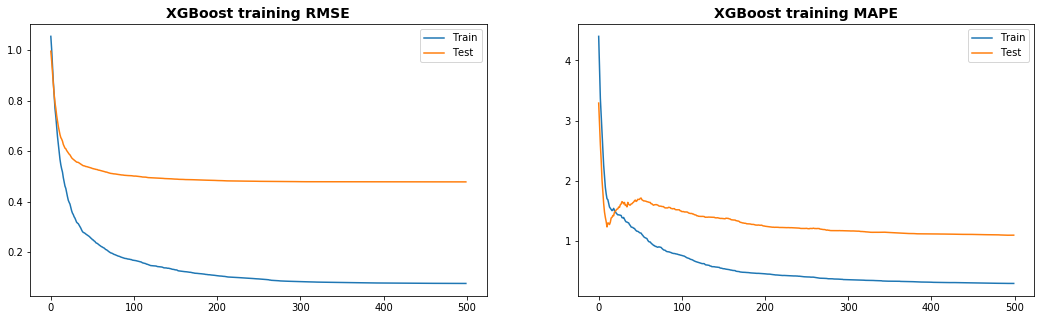

Prédiction de la consommation d'énergie :


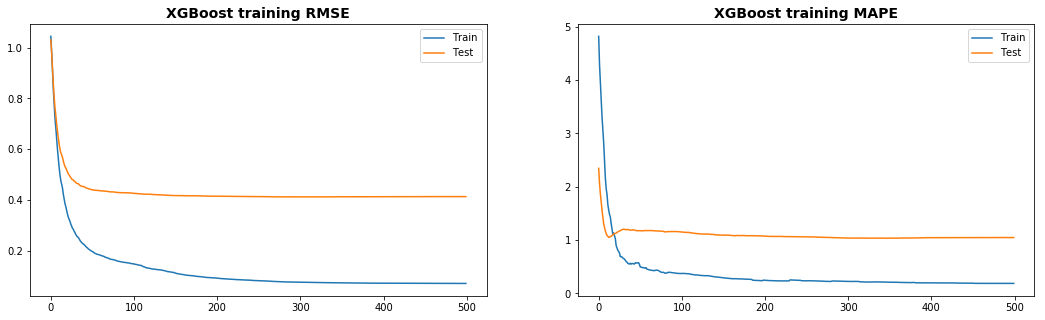

In [29]:
#On définit une fonction mettant en place un XGBoost et l'évaluant régulièrement sur les deux jeux de données 
def XGBoost_learning_curve(X_train, y_train, X_test, y_test, params):
    #On construit le jeu d'évaluation, à partir des deux jeux de données
    eval_set = [(X_train, y_train), (X_test, y_test)]
    #On construit le modèle via sklearn et on l'initialise avec le nombre d'estimateurs utilisés
    XGBoost = XGBRegressor(colsample_bytree=params['colsample_bytree'], learning_rate=params['learning_rate'],
                           max_depth=params['max_depth'], n_estimators=params['n_estimators'], seed=42)
    #Au moment de fitter l'algorithme, on demande à l'évaluer à chaque étape
    XGBoost.fit(X_train, y_train, eval_metric=["rmse", "mape"], eval_set=eval_set, verbose=0)
    #On récupère les résultats, avant de les afficher
    results = XGBoost.evals_result()
    x_axis = range(0, len(results['validation_0']['rmse']))
    #On affiche la courbe d'apprentissage pour la rmse
    fig = plt.figure(figsize=(18, 5))
    ax = fig.add_subplot(121)
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    #Attention : il s'agit de la RMSE pour les variables après passge au log, pas celle utilisée précédemment
    ax.set_title('XGBoost training RMSE', fontsize=14, fontweight='bold')
    #On affiche la courbe d'apprentissage pour la mape
    ax = fig.add_subplot(122)
    ax.plot(x_axis, results['validation_0']['mape'], label='Train')
    ax.plot(x_axis, results['validation_1']['mape'], label='Test')
    ax.legend()
    #Attention : il s'agit de la MAPE pour les variables après passge au log, pas celle utilisée précédemment
    ax.set_title('XGBoost training MAPE', fontsize=14, fontweight='bold')
    plt.show()
    return XGBoost

#On commence par l'émission de gaz à effets de serre
print("Prédiction de l'émission de gaz à effets de serre :")
XGBoost_stop_ghg = XGBoost_learning_curve(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg, clf_ghg.best_params_)

#On fait de même pour la consommation d'énergie
print("Prédiction de la consommation d'énergie :")
XGBoost_stop_nrj = XGBoost_learning_curve(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj, clf_nrj.best_params_)


Il semblerait qu'au bout d'un certain temps les performances sur le jeu de test n'évoluent plus. Afin de limiter le sur-apprentissage nous allons faire un arrêt prématuré de l'apprentissage de notre XGBoost.

In [30]:
#On définit une fonction mettant en place un XGBoost et l'arrêtant quand les performances de test stagnent 
def XGBoost_early_stop(X_train, y_train, X_test, y_test, params):
    #On construit le jeu d'évaluation qui servira pour déterminer le temps d'arrêt
    eval_set = [(X_test, y_test)]
    #On construit le modèle via sklearn et on l'initialise avec le nombre d'estimateurs utilisés
    XGBoost = XGBRegressor(colsample_bytree=params['colsample_bytree'], learning_rate=params['learning_rate'],
                           max_depth=params['max_depth'], n_estimators=params['n_estimators'], seed=42)
    #Au moment de fitter l'algorithme, on lui demande de s'arrêter après 10 étapes sans amélioration des performances
    XGBoost.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=0)
    return XGBoost

#On commence par l'émission de gaz à effets de serre
XGBoost_stop_ghg = XGBoost_early_stop(X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg, clf_ghg.best_params_)
indicateurs_finaux["Emission de gaz - XGBoost Early Stop"] = indic_performances(XGBoost_stop_ghg, X_train_ghg, y_train_ghg, X_test_ghg, y_test_ghg)

#On fait de même pour la consommation d'énergie
XGBoost_stop_nrj = XGBoost_early_stop(X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj, clf_nrj.best_params_)
indicateurs_finaux["Consommation d'énergie - XGBoost Early Stop"] = indic_performances(XGBoost_stop_nrj, X_train_nrj, y_train_nrj, X_test_nrj, y_test_nrj)

#On affiche les indicateurs finaux
indicateurs_finaux.transpose().head(6)

,RMSE train,RMSE test,R² train,R² test,MAPE train,MAPE test
Emission de gaz - XGBoost par défaut,0.440072,1.154568,0.946398,0.687001,0.153170,0.406548
Consommation d'énergie - XGBoost par défaut,0.335202,1.011198,0.975116,0.796716,0.117876,0.312257
Emission de gaz - XGBoost Validation Croisée,0.109828,0.999520,0.996661,0.765422,0.034764,0.335472
Consommation d'énergie - XGBoost Validation Croisée,0.143444,0.919444,0.995443,0.831933,0.029529,0.259462
Emission de gaz - XGBoost Early Stop,0.140284,1.005798,0.994553,0.762466,0.047513,0.343138
Consommation d'énergie - XGBoost Early Stop,0.150109,0.920522,0.995010,0.831539,0.036226,0.258910


L'arrêt prématuré permet de réduire l'écart entre les performances sur nos deux jeux de données, diminuant ainsi l'effet de sur-apprentissage sans altérer l'efficacité sur le jeu de test.

## Impact de l'EnergyStarScore

Nous allons ajouter l'EnergyStarScore aux données exploitables, avant d'y appliquer notre algorithme optimisé pour la prédiction de l'émission de gaz à effets de serre. Comparer les performances de cet algorithme avec et sans la variable *ENERGYSTARScore* nous donnera un aperçu de l'impact de l'EnergyStarScore sur la variable à prédire et de l'intérêt qu'il faut porter au calcul de cet indice lors de la construction d'un bâtiment.

In [31]:
#On commence par ajouter l'ENERGYSTARScore aux variables exploitées
X_train_ess = train_ghg.drop(columns = ['GHGE_log'])
X_test_ess = test_ghg.drop(columns = ['GHGE_log'])

#On simule notre XGBoost optimal pour l'émission de gaz sur ce nouveau dataset, avant de récupérer les indicateurs
XGBoost_ghg_ess = XGBoost_early_stop(X_train_ess, y_train_ghg, X_test_ess, y_test_ghg, clf_ghg.best_params_)
indicateurs_finaux["Emission de gaz - XGBoost Early Stop avec ESS"] = indic_performances(XGBoost_ghg_ess, X_train_ess,
                                                                      y_train_ghg, X_test_ess, y_test_ghg)

#On affiche les indicateurs finaux
indicateurs_finaux.transpose().head(7)

,RMSE train,RMSE test,R² train,R² test,MAPE train,MAPE test
Emission de gaz - XGBoost par défaut,0.440072,1.154568,0.946398,0.687001,0.153170,0.406548
Consommation d'énergie - XGBoost par défaut,0.335202,1.011198,0.975116,0.796716,0.117876,0.312257
Emission de gaz - XGBoost Validation Croisée,0.109828,0.999520,0.996661,0.765422,0.034764,0.335472
Consommation d'énergie - XGBoost Validation Croisée,0.143444,0.919444,0.995443,0.831933,0.029529,0.259462
Emission de gaz - XGBoost Early Stop,0.140284,1.005798,0.994553,0.762466,0.047513,0.343138
Consommation d'énergie - XGBoost Early Stop,0.150109,0.920522,0.995010,0.831539,0.036226,0.258910
Emission de gaz - XGBoost Early Stop avec ESS,0.099724,1.021183,0.997247,0.755144,0.025394,0.302559


L'*ENERGYSTARScore* semble améliorer les performances de l'algorithme si on se base sur la MAPE (qui est l'indicateur le plus impacté par ce changement). C'est donc en théorie un ajout pertinent aux variables d'étude mais  l'impact qu'il a sur la prédiction de l'émission de gaz à effets de serre reste minime. Au vu du coût de production de l'EnergyStarScore, il vaut certainement mieux s'en passer lors de l'utilisation de notre algorithme de prédiction.